In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft

In [44]:
d = 1; c = 3.0*10**8
wp = 2*np.pi*c/(1.03*10**-6); ws = 3/5*wp;  wi = 2*(wp-ws); w2i = 2*wi #Frequencies

ns = 2.01; n_p = 2.02; ni = 2; n2i = 2.01 #Indexes of refraction. 
#n_p 2.04

ks = ns*ws/c; kp = n_p*wp/c; ki = ni*wi/c; k2i = n2i*w2i/c
delta_k_OPA = np.abs(kp-ks-ki)#*0
delta_k_SHG = np.abs(k2i-2*ki)#*0

Ks = 1j*ws*d/(ns*c)
Kp = 1j*wp*d/(n_p*c)
Ki = 1j*wi*d/(ni*c)
K2i = 1j*w2i*d/(2*n2i*c)
#print(delta_k_OPA)
#print(delta_k_SHG)

In [53]:
z_max = 14*10**-3 #3cm
z = np.linspace(0,z_max,200000)
I_s = 2*ns*c*8.9**-12 
I_p = 2*n_p*c*8.9**-12
I_i = 2*ni*c*8.9**-12
I_2i = 2*n2i*c*8.9**-12
As = 0.0001+0.0j; Ap = As*10; Ai = 0.0+0.0j; A2i = 0.0+0.0j #Gain is pretty much the minimum at 10.

y0 = [As, Ap, Ai, A2i]
y1 = [As/10, Ap, Ai, A2i]
y2 = [As/100, Ap, Ai, A2i]

from tqdm import tqdm
def RK4(dydx, z, y0, d_eff):    
    h = (z[1]-z[0])
    h_list = np.full(shape = len(y0), fill_value = h, dtype = float)
    y = np.zeros([len(z+1), len(y0)],dtype = complex)  
    y[0] = y0

    for iters, z_iters in enumerate(tqdm(z,desc=dydx.__name__)):
        k1 = h_list * dydx(z_iters, y[iters], iters,d_eff)
        k2 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k1, iters,d_eff)
        k3 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k2, iters,d_eff)
        k4 = h_list * dydx(z_iters + h, y[iters] + k3, iters,d_eff)
        
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return y

d_eff_C = np.sign(np.sin(z*delta_k_OPA)+np.sin(z*delta_k_SHG)) #np.full(len(z),fill_value = 1) 
d_eff_U = np.sign(1.2*np.sin(z*delta_k_OPA)+np.sin(z*delta_k_SHG))
d_eff_O = np.sign(np.sin(z*delta_k_OPA)+1.2*np.sin(z*delta_k_SHG))
def dAdz(z,S,iters,d_eff):
    As, Ap, Ai, A2i = S
    return  (d_eff[iters]*Ks*Ap*np.conj(Ai)*np.exp(1j*delta_k_OPA*z), 
            d_eff[iters]*Kp*As*Ai*np.exp(-1j*delta_k_OPA*z), 
            d_eff[iters]*Ki*(Ap*np.conj(As)*np.exp(1j*delta_k_OPA*z)+A2i*np.conj(Ai)*
            np.exp(1j*delta_k_SHG*z)), 
            d_eff[iters]*K2i*Ai**2*np.exp(-1j*delta_k_SHG*z))

y_list_U1 = RK4(dAdz, z, y0, d_eff_U)
Ap_list_U1 = I_p*(np.abs(y_list_U1[:,1])**2)
y_list_U2 = RK4(dAdz, z, y1, d_eff_U)
Ap_list_U2 = I_p*(np.abs(y_list_U2[:,1])**2)
y_list_U3 = RK4(dAdz, z, y2, d_eff_U)
Ap_list_U3 = I_p*(np.abs(y_list_U3[:,1])**2)
y_list_C1 = RK4(dAdz, z, y0, d_eff_C)
Ap_list_C1 = I_p*(np.abs(y_list_C1[:,1])**2)
y_list_C2 = RK4(dAdz, z, y1, d_eff_C)
Ap_list_C2 = I_p*(np.abs(y_list_C2[:,1])**2)
y_list_C3 = RK4(dAdz, z, y2, d_eff_C)
Ap_list_C3 = I_p*(np.abs(y_list_C3[:,1])**2)
y_list_O1 = RK4(dAdz, z, y0, d_eff_O)
Ap_list_O1 = I_p*(np.abs(y_list_O1[:,1])**2)
y_list_O2 = RK4(dAdz, z, y1, d_eff_O)
Ap_list_O2 = I_p*(np.abs(y_list_O2[:,1])**2)
y_list_O3 = RK4(dAdz, z, y2, d_eff_O)
Ap_list_O3 = I_p*(np.abs(y_list_O3[:,1])**2)



dAdz: 100%|█████████▉| 199999/200000 [00:56<00:00, 3568.25it/s]


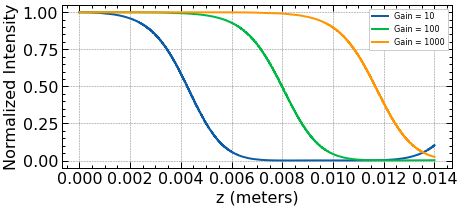

In [58]:
# ax1 = plt.subplot(321)          
# ax1.plot(z,Ap_list_U1/np.amax(Ap_list_C3))
# ax1.plot(z,Ap_list_U2/np.amax(Ap_list_C3))
# ax1.plot(z,Ap_list_U3/np.amax(Ap_list_C3))
# ax1.set_title('U^2 under')
plt.figure(figsize=(7,3))
plt.plot(z, Ap_list_O1/np.amax(Ap_list_C3))
plt.plot(z, Ap_list_O2/np.amax(Ap_list_C3))
plt.plot(z, Ap_list_O3/np.amax(Ap_list_C3))
plt.xlabel("z (meters)")
plt.ylabel("Normalized Intensity")
plt.legend(["Gain = 10", "Gain = 100", "Gain = 1000"],prop={'size': 8})
# ax2 = plt.subplot(322)          
# ax2.plot(z,Ap_list_C1/np.amax(Ap_list_C3))
# ax2.plot(z,Ap_list_C2/np.amax(Ap_list_C3))
# ax2.plot(z,Ap_list_C3/np.amax(Ap_list_C3))
# ax2.set_title('U^2 critical')

# ax3 = plt.subplot(323)          
# ax3.plot(z,Ap_list_O1/np.amax(Ap_list_C3))
# ax3.plot(z,Ap_list_O2/np.amax(Ap_list_C3))
# ax3.plot(z,Ap_list_O3/np.amax(Ap_list_C3))
# ax3.set_title('U^2 over')
plt.savefig('Over.png', bbox_inches='tight')

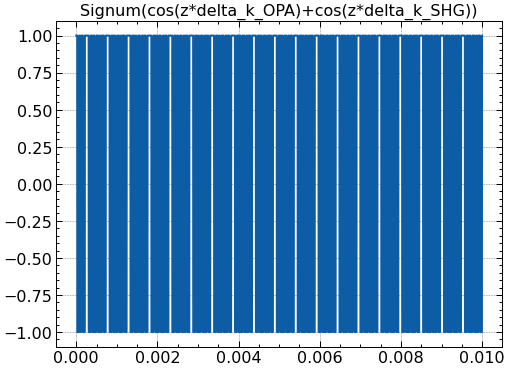

In [13]:
plt.plot(z,np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)))
plt.title("Signum(cos(z*delta_k_OPA)+cos(z*delta_k_SHG))")
plt.show()

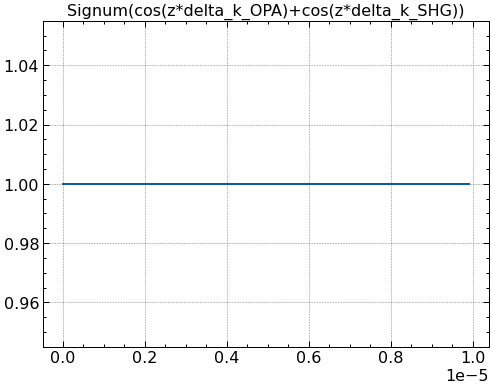

In [14]:
plt.plot(z[:100],np.sign(np.cos(z[:100]*delta_k_OPA)+np.cos(z[:100]*delta_k_SHG)))
plt.title("Signum(cos(z*delta_k_OPA)+cos(z*delta_k_SHG))")
plt.show()

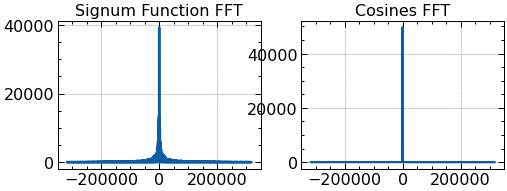

In [15]:
timestep = z_max/20000
r1 = fft(np.sign(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG)))
n1 = r1.size

freq1 = fftfreq(n1, timestep)/np.pi

r2 = fft(np.cos(z*delta_k_OPA)+np.cos(z*delta_k_SHG))
n2 = r2.size

freq2 = fftfreq(n2, timestep)/np.pi

ax1 = plt.subplot(221)          
ax1.plot(freq1,np.abs(r1))
ax1.set_title('Signum Function FFT')

ax2 = plt.subplot(222)
ax2.plot(freq2,np.abs(r2))
ax2.set_title('Cosines FFT')


#plt.plot(freq1,np.abs(y))
#plt.plot(freq2,np.abs(x))
plt.show()

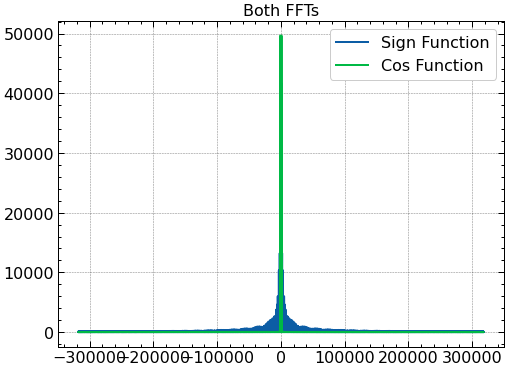

In [16]:
plt.plot(freq1,np.abs(r1))
plt.plot(freq2,np.abs(r2))
plt.title("Both FFTs")
plt.legend(["Sign Function","Cos Function"])
plt.show()

## References:

[1]: Boyd, Robert W. Nonlinear Optics. San Diego, CA: Academic Press, 2003. Print.

[2]: Jeffrey Moses, Noah Flemens, and Xiaoyue Ding "Back-conversion suppressed parametric frequency conversion for ultrawide bandwidth and ultrahigh efficiency devices", Proc. SPIE 11264, Nonlinear Frequency Generation and Conversion: Materials and Devices XIX, 112640B (2 March 2020); https://doi.org/10.1117/12.2548361

[3]: Andrew H. Norton and C. Martijn de Sterke, "Aperiodic 1-dimensional structures for quasi-phase matching," Opt. Express 12, 841-846 (2004)